In [1]:
import argparse
import time
import os
import random

from cnnrnn_model import CNNRNNModel
from attention_model import AttentionModel
from mean_model import MeanModel
from modeltransformer import TransformerModel
from finetune import FineTuningModel
from bertmodel import BertModel
from bertbilstmmodel import BertBiLSTMModel
from preprocessing import Preprocessing
import pandas as pd
from modelconfiguration import ModelConfig

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aargente/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aargente/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
config = ModelConfig.MeanModelConfig.value
model = MeanModel(batch_size=config['batch_size'], epochs=config['epochs'],
                  vocab_size=config['vocab_size'],
                  max_len=config['max_len'], filters=config['filters'], kernel_size=config['kernel_size'],
                  optimizer=config['optimizer'], learning_rate=config['learning_rate'],
                  max_sequence_len=config['max_sequence_len'], lstm_units=config['lstm_units'],
                  embedding_size=config['embedding_size'], load_embeddings=config['load_embeddings'],
                  pool_size=config['pool_size'], path_train=config['path_train'],
                  path_test=config['path_test'], path_dev=config['path_dev'], emb_type=config['emb_type'],
                  buffer_size=config['buffer_size'], rate=config['rate'],
                  length_type=config['length_type'],
                  dense_units=config['dense_units']
                  )
model.prepare_data_as_tensors()

Weight for class 0: 0.56
Weight for class 1: 4.47
MODEL CONFIGURATION
Max Sequence Length: 455
Epochs for training: 15
Bath Size: 16
Embeddings Selected: fasttext
Dense Units: 64
Learning Rate: 0.001
Dropout Rate: 0.15
L2 Regularization Rate: 1e-05
Loading data
Padding sentences
Se usará la mediana como max_sequence_len.
The max_sequence_len is:  463
Tras padding
Loading Vocabulary and Embeddings Matrix
Loading FastText Embeddings.
Embeddings cargados
Word index: 305152
Total number of null words: 193457
Loading data as tensors


In [3]:
print('Building the model.')
model.call()

Building the model.
Model: "mean_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 463)]        0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 463, 300)     91545600    seq_input[0][0]                  
__________________________________________________________________________________________________
bilstm (Bidirectional)          [(None, 463, 128), ( 186880      embeddings[0][0]                 
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           bilstm[0][1]                     
                                                                 bils

In [4]:
print('Previo a fit')
model.fit_as_tensors(with_validation=False)
print('Previo a predict')
model.predict_test_dev()

Previo a fit
Epoch 1/15
2250/2250 [==============================] - 95s 42ms/step - loss: 0.3024 - accuracy: 0.8726 - lr: 0.0010
Epoch 2/15
2250/2250 [==============================] - 94s 42ms/step - loss: 0.1929 - accuracy: 0.9267 - lr: 0.0010
Epoch 3/15
2250/2250 [==============================] - 94s 42ms/step - loss: 0.1542 - accuracy: 0.9454 - lr: 0.0010
Epoch 4/15
2250/2250 [==============================] - 94s 42ms/step - loss: 0.1221 - accuracy: 0.9608 - lr: 0.0010
Epoch 5/15
2250/2250 [==============================] - 94s 42ms/step - loss: 0.0938 - accuracy: 0.9713 - lr: 0.0010
Epoch 6/15
2250/2250 [==============================] - 94s 42ms/step - loss: 0.0738 - accuracy: 0.9802 - lr: 0.0010
Epoch 7/15
2250/2250 [==============================] - 94s 42ms/step - loss: 0.0652 - accuracy: 0.9839 - lr: 0.0010
Epoch 8/15
2250/2250 [==============================] - 95s 42ms/step - loss: 0.0545 - accuracy: 0.9890 - lr: 0.0010
Epoch 9/15
2250/2250 [=============================

In [5]:
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML # To use with Jupyter Notebook
import seaborn as sns
from tensorflow.keras.models import Model
import numpy as np

In [6]:
def plot_attention():
    if model is None:
        raise ValueError("The model must be fitted before using this function.")
    # New model for getting att_weights
    model_att = Model(inputs=model.model.inputs,
                      outputs=[model.model.outputs, model.model.get_layer('attention_layer').output])
    # Get a random instance
    idx = np.random.randint(low=0, high=len(model.X_test))
    # print(idx)
    tokenized_sample = np.trim_zeros(model.X_test[idx])
    # print(model.test.text[idx:idx+1].values[0])
    # print(tokenized_sample)
    pred, attention = model_att.predict(model.X_test[idx:idx+1], verbose=0)
    pred = pred[0][0]
    # print(pred)
    # Get the decoded sentence
    sentence = dict(map(reversed, model.tokenizer.word_index.items()))
    decoded_sentence = [sentence[word] for word in tokenized_sample]
    
    # Get the prediction
    label = 1 if pred[0] > pred[1] else 0
    # label = (pred > 0.5).astype(int).squeeze()
    labelsid = ['No Propaganda', 'Propaganda']
    # print(label)
    true_label = model.y_test[idx:idx+1][0]
    # print(true_label)
    true_label = 1 if true_label[0] > true_label[1] else 0
    # print(true_label)
    # attention output:

    # Get word attentions using attention vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    """
    attentions_text = attention[0, -len(tokenized_sample):]
    # plt.bar(np.arange(0,len(attentions.squeeze())), attentions.squeeze())
    # plt.show();
    # print(attentions_text)
    attentions_text = (attentions_text - np.min(attentions_text)) / (
                np.max(attentions_text) - np.min(attentions_text))

    for token, att_Score in zip(decoded_sentence, attentions_text):
        token_attention_dic[token] = att_Score
    """
    # print(attention[0][-len(tokenized_sample):])
    attention = attention[0]
    # attentions_text = attention[0][-len(tokenized_sample):]
    attentions_text = attention[0, -len(tokenized_sample):]
    attentions_text = (attentions_text - np.min(attentions_text)) / (
                np.max(attentions_text) - np.min(attentions_text))
    # print(attentions_text[0])
    # attentions_text = attentions_text[0]
    for token, attention_score in zip(decoded_sentence, attentions_text):
        token_attention_dic[token] = attention_score

    # Build HTML String to viualize attentions
    # USE THIS ONLY IN Jupyter Notebook

    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention_t in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention_t[0]), token)
    html_text += "</p><br>"
    html_text += "<p style='font-size: large'><b>Classified as:</b> "
    html_text += labelsid[label] 
    html_text += "</p>"
    html_text += "</p><br>"
    html_text += "<p style='font-size: large'><b>Original label is:</b> "
    html_text += str(true_label)
    html_text += "</p>"
    # Display text enriched with attention scores
    display(HTML(html_text))
    # print(model.y_test[idx:idx+1][0])
    # PLOT PROPAGANDA SCORE
    _labels = ['propaganda', 'no propaganda']
    plt.figure(figsize=(5, 2))
    plt.bar(np.arange(len(_labels)), pred.squeeze(), align='center', alpha=0.5,
            color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    figname = 'att_plots/attention_score' + str(idx) + '.png'
    # plt.savefig(figname)
    plt.show()

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    
    color = rgb_to_hex((255, r, r))
    return str(color)

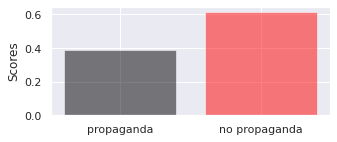

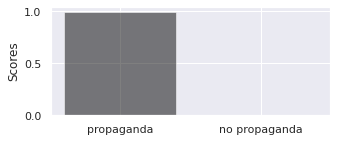

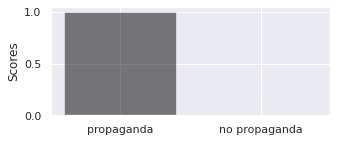

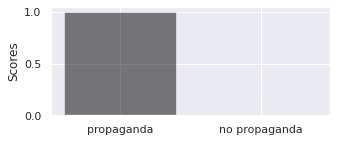

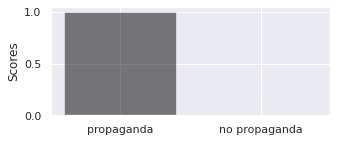

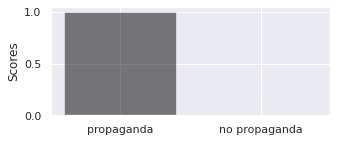

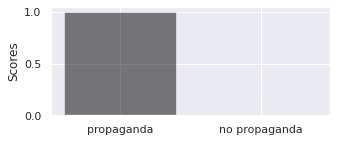

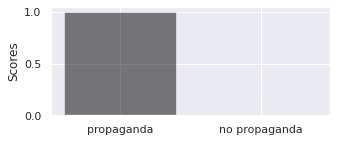

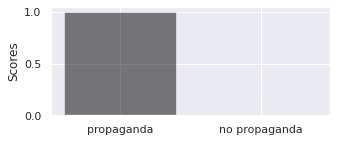

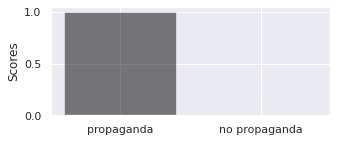

In [76]:
for _ in range(10):
    plot_attention()

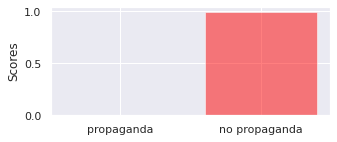

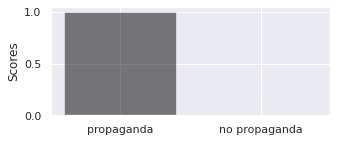

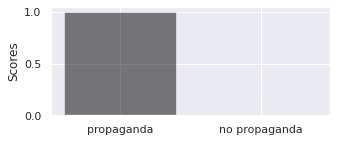

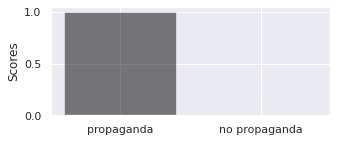

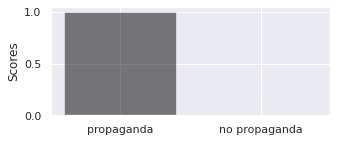

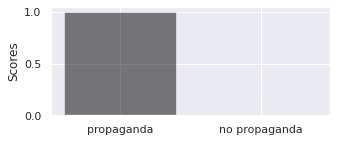

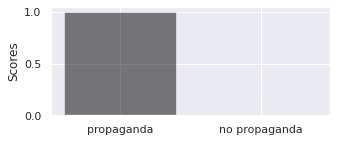

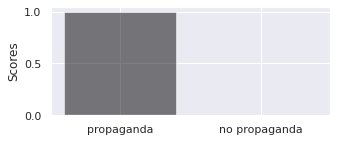

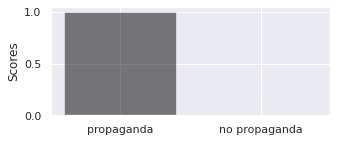

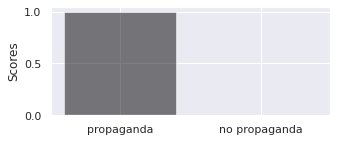

In [77]:
for _ in range(10):
    plot_attention()

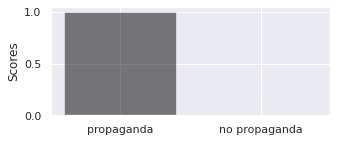

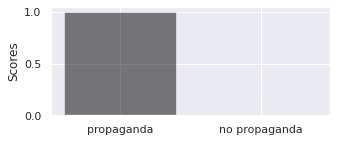

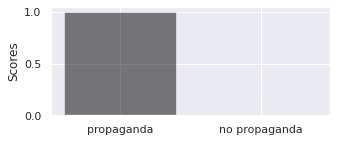

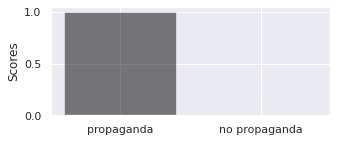

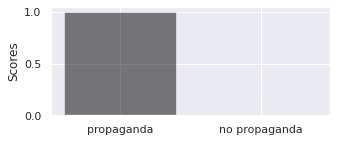

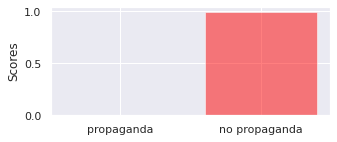

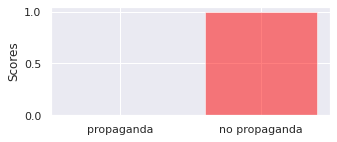

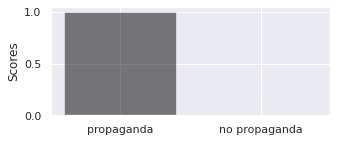

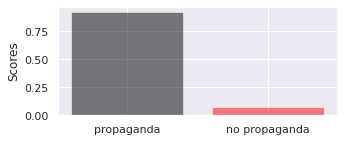

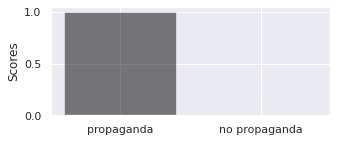

In [79]:
for _ in range(10):
    plot_attention()

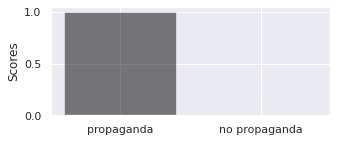

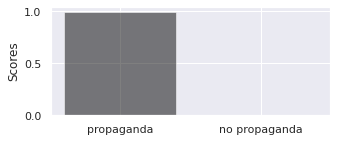

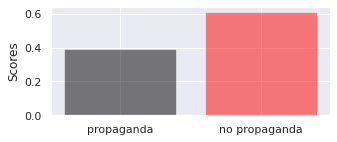

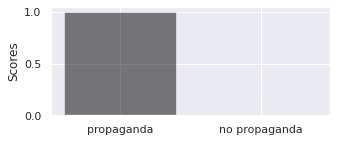

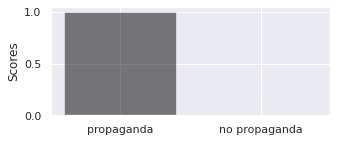

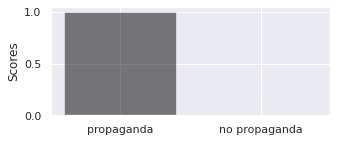

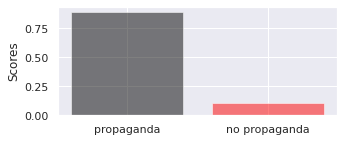

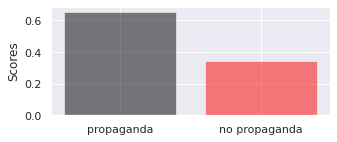

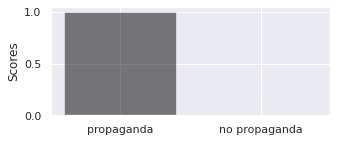

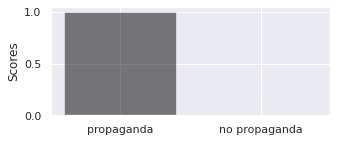

In [82]:
for _ in range(10):
    plot_attention()

In [7]:
config = ModelConfig.SecondExperiment.value
model_exp2 = MeanModel(batch_size=config['batch_size'], epochs=config['epochs'], vocab_size=config['vocab_size'],
                    max_len=config['max_len'], filters=config['filters'], kernel_size=config['kernel_size'],
                    optimizer=config['optimizer'], learning_rate=config['learning_rate'],
                    max_sequence_len=config['max_sequence_len'], lstm_units=config['lstm_units'],
                    embedding_size=config['embedding_size'], load_embeddings=config['load_embeddings'],
                    pool_size=config['pool_size'], path_train=config['path_train'],
                    path_test=config['path_test'], path_dev=None, emb_type=config['emb_type'],
                    buffer_size=config['buffer_size'], rate=config['rate'], length_type=config['length_type'],
                    dense_units=config['dense_units']
                    )
model_exp2.prepare_data_as_tensors()
print('Building the model.')
model_exp2.call()
print('Previo a fit')
model_exp2.fit_as_tensors(with_validation=False)
print('Previo a predict')
model_exp2.predict()

Weight for class 0: 0.56
Weight for class 1: 4.47
MODEL CONFIGURATION
Max Sequence Length: 455
Epochs for training: 15
Bath Size: 16
Embeddings Selected: fasttext
Dense Units: 128
Learning Rate: 0.001
Dropout Rate: 0.15
L2 Regularization Rate: 1e-05
Loading data
Padding sentences
Se usará la mediana como max_sequence_len.
The max_sequence_len is:  467
Tras padding
Loading Vocabulary and Embeddings Matrix
Loading FastText Embeddings.
Embeddings cargados
Word index: 305152
Total number of null words: 193457
Loading data as tensors
Building the model.
Model: "mean_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 467)]        0                                            
__________________________________________________________________________________________________
embeddings (Embedding)       

In [8]:
def plot_attention2():
    if model is None:
        raise ValueError("The model must be fitted before using this function.")
    # New model for getting att_weights
    model_att = Model(inputs=model_exp2.model.inputs,
                      outputs=[model_exp2.model.outputs, model_exp2.model.get_layer('attention_layer').output])
    # Get a random instance
    idx = np.random.randint(low=0, high=len(model_exp2.X_test))
    # print(idx)
    tokenized_sample = np.trim_zeros(model_exp2.X_test[idx])
    # print(model.test.text[idx:idx+1].values[0])
    # print(tokenized_sample)
    pred, attention = model_att.predict(model_exp2.X_test[idx:idx+1], verbose=0)
    pred = pred[0][0]
    # print(pred)
    # Get the decoded sentence
    sentence = dict(map(reversed, model_exp2.tokenizer.word_index.items()))
    decoded_sentence = [sentence[word] for word in tokenized_sample]
    
    # Get the prediction
    label = 1 if pred[0] > pred[1] else 0
    # label = (pred > 0.5).astype(int).squeeze()
    labelsid = ['No Propaganda', 'Propaganda']
    # print(label)
    true_label = model_exp2.y_test[idx:idx+1][0]
    # print(true_label)
    true_label = 1 if true_label[0] > true_label[1] else 0
    # print(true_label)
    # attention output:

    # Get word attentions using attention vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    """
    attentions_text = attention[0, -len(tokenized_sample):]
    # plt.bar(np.arange(0,len(attentions.squeeze())), attentions.squeeze())
    # plt.show();
    # print(attentions_text)
    attentions_text = (attentions_text - np.min(attentions_text)) / (
                np.max(attentions_text) - np.min(attentions_text))

    for token, att_Score in zip(decoded_sentence, attentions_text):
        token_attention_dic[token] = att_Score
    """
    # print(attention[0][-len(tokenized_sample):])
    attention = attention[0]
    # attentions_text = attention[0][-len(tokenized_sample):]
    attentions_text = attention[0, -len(tokenized_sample):]
    attentions_text = (attentions_text - np.min(attentions_text)) / (
                np.max(attentions_text) - np.min(attentions_text))
    # print(attentions_text[0])
    # attentions_text = attentions_text[0]
    for token, attention_score in zip(decoded_sentence, attentions_text):
        token_attention_dic[token] = attention_score

    # Build HTML String to viualize attentions
    # USE THIS ONLY IN Jupyter Notebook

    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention_t in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention_t[0]), token)
    html_text += "</p><br>"
    html_text += "<p style='font-size: large'><b>Classified as:</b> "
    html_text += labelsid[label] 
    html_text += "</p>"
    html_text += "</p><br>"
    html_text += "<p style='font-size: large'><b>Original label is:</b> "
    html_text += str(true_label)
    html_text += "</p>"
    # Display text enriched with attention scores
    display(HTML(html_text))
    # print(model_exp2.y_test[idx:idx+1][0])
    # PLOT PROPAGANDA SCORE
    _labels = ['propaganda', 'no propaganda']
    plt.figure(figsize=(5, 2))
    plt.bar(np.arange(len(_labels)), pred.squeeze(), align='center', alpha=0.5,
            color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    figname = 'att_plots/attention_score' + str(idx) + '.png'
    # plt.savefig(figname)
    plt.show()

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    
    color = rgb_to_hex((255, r, r))
    return str(color)

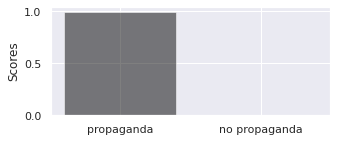

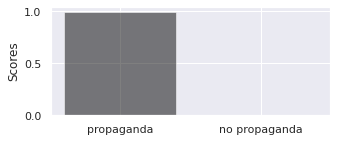

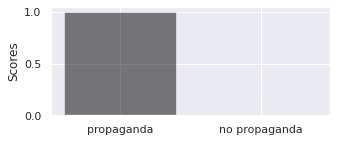

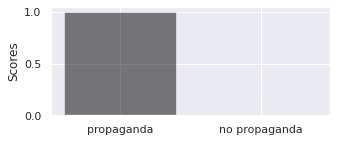

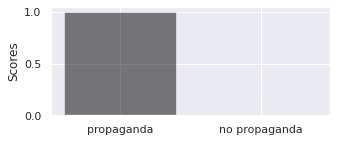

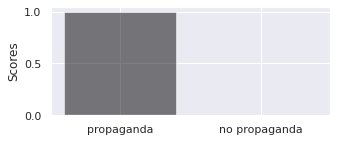

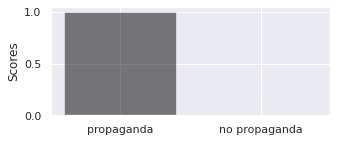

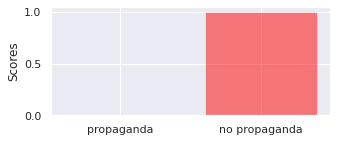

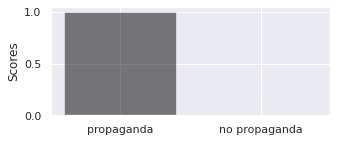

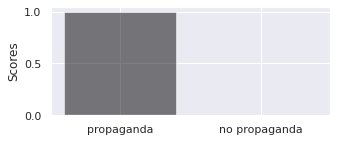

In [10]:
for _ in range(10):
    plot_attention2()

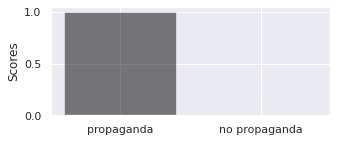

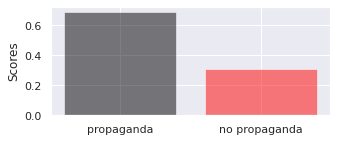

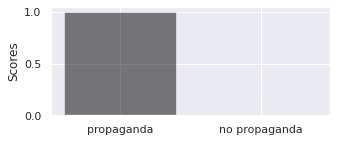

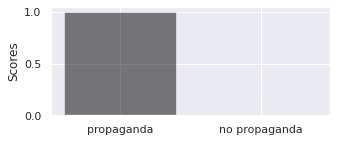

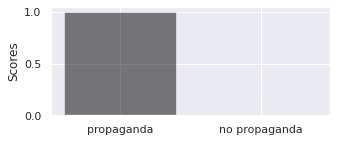

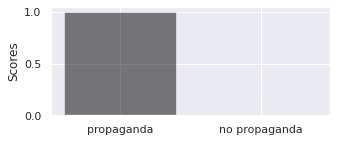

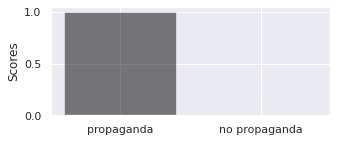

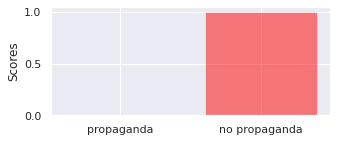

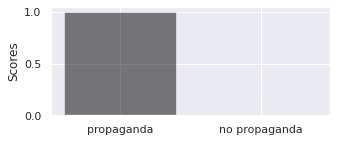

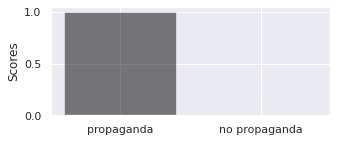

In [11]:
for _ in range(10):
    plot_attention2()

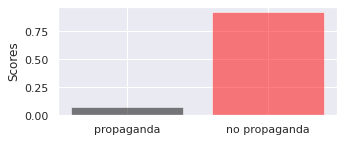

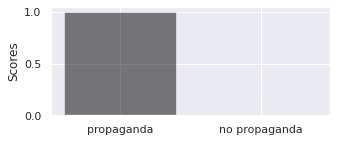

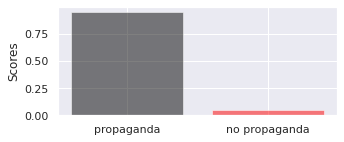

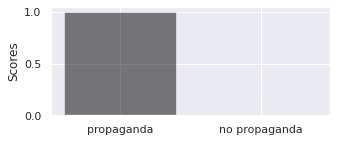

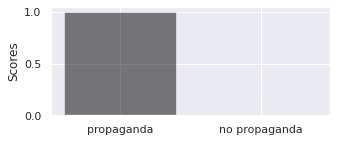

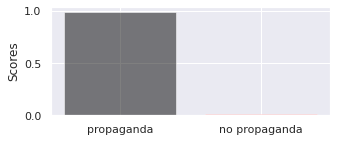

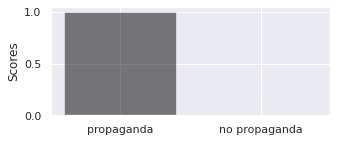

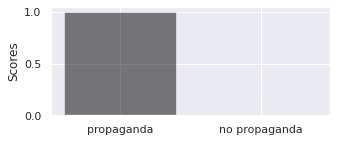

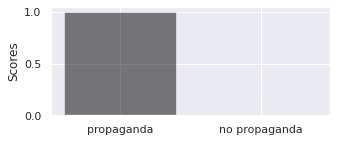

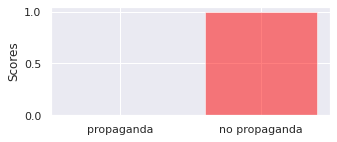

In [12]:
for _ in range(10):
    plot_attention2()

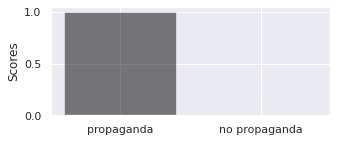

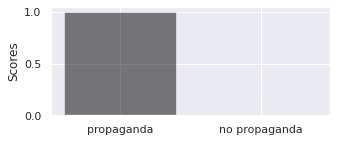

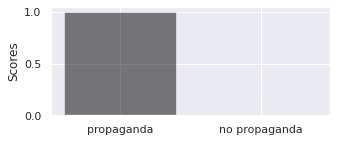

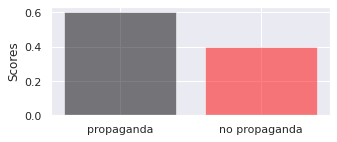

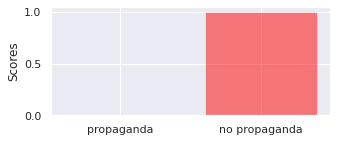

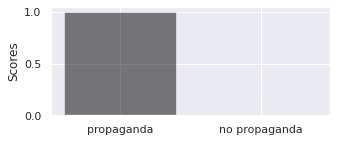

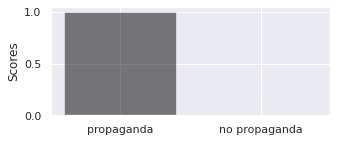

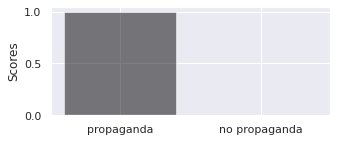

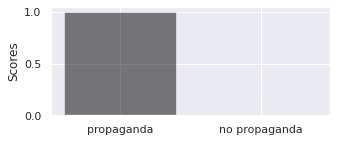

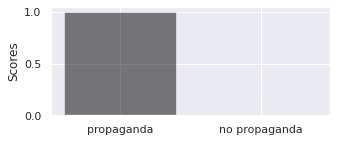

In [13]:
for _ in range(10):
    plot_attention2()

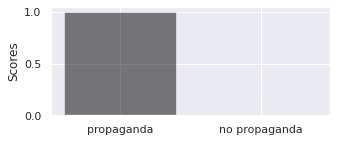

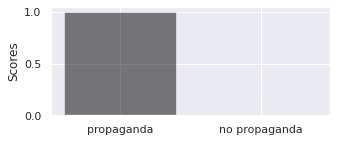

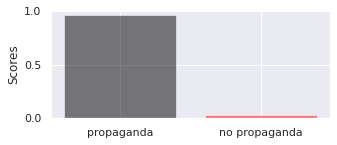

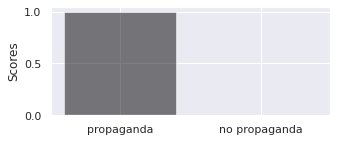

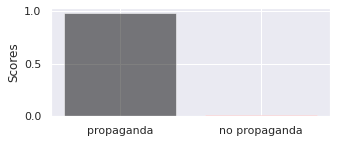

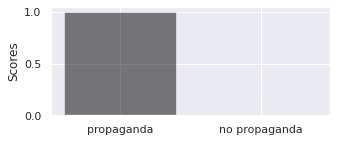

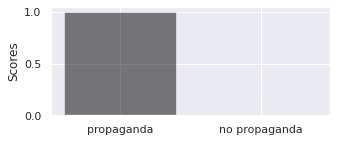

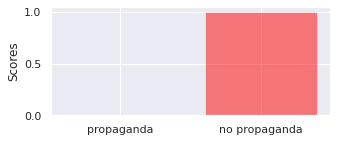

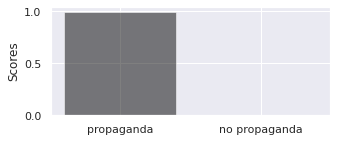

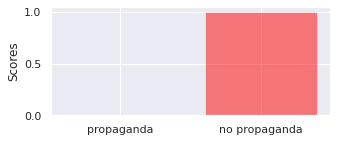

In [17]:
for _ in range(10):
    plot_attention2()